In [ ]:
import subprocess, shlex
from Bio import SeqIO, Seq
from Bio.Blast import NCBIXML

from io import StringIO
import io, os

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex

# from ete3 import Tree, faces, TreeStyle, TextFace, CircleFace

In [84]:
import numpy as np
import pandas as pd
from datetime import datetime
from multiprocessing import Pool

from Bio import SeqIO
import requests
from io import StringIO as sio
from io import StringIO
from collections import defaultdict

import dendropy
import itertools
from tqdm.notebook import trange, tqdm

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.lines import Line2D

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex
from matplotlib.transforms import ScaledTranslation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import src.baltic as bt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.sans-serif'] = ['Arial']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
# genotype = pd.read_csv('new_genotype.csv', sep='\t', index_col=0)
# isl2genotype = genotype['genotype'].to_dict()

In [4]:
seg_l = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'NS', 'MP']

In [5]:
# isl info
isl_info_h5 = pd.read_csv('isl_info_h5.csv', sep='\t', keep_default_na=False, index_col=0)
# seg info
seg_info_h5 = pd.read_csv('seg_info_h5.csv', sep='\t', keep_default_na=False, index_col=2)
seg_info_h5['Subtype'] = 'A/H5N8'

isl_info_h5.shape, seg_info_h5.shape

((3781, 25), (34760, 16))

In [6]:
all_aiv_metainfo_file = ['1.gisaid_epiflu_isolates.xls', '2.gisaid_epiflu_isolates.xls','3.gisaid_epiflu_isolates.xls']
all_aiv_metainfo = pd.concat([pd.read_excel(f'./data/all_aiv2/{l}') for l in all_aiv_metainfo_file], ignore_index=True).set_index('Isolate_Id')

all_aiv_metainfo = all_aiv_metainfo[['Isolate_Name', 'Subtype', 'Location', 'Host', 'Collection_Date', 'Domestic_Status']]

In [7]:
all_aiv_metainfo = all_aiv_metainfo[~all_aiv_metainfo.index.duplicated(keep='last')]
all_aiv_metainfo.head()

Isolate_Name   Subtype  \
Isolate_Id                                                        
EPI_ISL_98897  A/peregrine falcon/Kyoto/2602A009/2011  A / H5N1   
EPI_ISL_98896  A/peregrine falcon/Aichi/2302O017/2011  A / H5N1   
EPI_ISL_66243  A/Egyptian goose/South Africa/AI23/04   A / H5N2   
EPI_ISL_66202                  A/goose/Wien/1966/2006  A / H5N1   
EPI_ISL_66116                           A/goose/nfav1  A / H5N1   

                            Location              Host Collection_Date  \
Isolate_Id                                                               
EPI_ISL_98897           Asia / Japan  Falco peregrinus      2011-02-16   
EPI_ISL_98896           Asia / Japan  Falco peregrinus      2011-02-17   
EPI_ISL_66243  Africa / South Africa             Goose         2004-08   
EPI_ISL_66202       Europe / Austria             Goose      2006-04-03   
EPI_ISL_66116           Asia / China             Goose            1970   

              Domestic_Status  
Isolate_Id                     
EPI_ISL_98897             NaN  
EPI_ISL_98896             NaN  
EPI_ISL_66243             NaN  
EPI_ISL_66202             NaN  
EPI_ISL_66116             NaN

In [8]:
all_aiv_metainfo['date'] = pd.to_datetime(all_aiv_metainfo.Collection_Date)

all_aiv_metainfo['host'] = all_aiv_metainfo.Isolate_Name.str.split('/').str.get(1)
all_aiv_metainfo['region'] = all_aiv_metainfo.Location.str.split(' / ').str.get(0)
all_aiv_metainfo['country'] = all_aiv_metainfo.Location.str.split(' / ').str.get(1)
all_aiv_metainfo['provincie'] = all_aiv_metainfo.Location.str.split(' / ').str.get(2)
all_aiv_metainfo['city'] = all_aiv_metainfo.Location.str.split(' / ').str.get(3)

all_aiv_metainfo = all_aiv_metainfo.fillna('')

print(f"Total number of isolates: {all_aiv_metainfo.shape[0]}")

all_aiv_metainfo.head()

Total number of isolates: 53496


Isolate_Name   Subtype  \
Isolate_Id                                                        
EPI_ISL_98897  A/peregrine falcon/Kyoto/2602A009/2011  A / H5N1   
EPI_ISL_98896  A/peregrine falcon/Aichi/2302O017/2011  A / H5N1   
EPI_ISL_66243  A/Egyptian goose/South Africa/AI23/04   A / H5N2   
EPI_ISL_66202                  A/goose/Wien/1966/2006  A / H5N1   
EPI_ISL_66116                           A/goose/nfav1  A / H5N1   

                            Location              Host Collection_Date  \
Isolate_Id                                                               
EPI_ISL_98897           Asia / Japan  Falco peregrinus      2011-02-16   
EPI_ISL_98896           Asia / Japan  Falco peregrinus      2011-02-17   
EPI_ISL_66243  Africa / South Africa             Goose         2004-08   
EPI_ISL_66202       Europe / Austria             Goose      2006-04-03   
EPI_ISL_66116           Asia / China             Goose            1970   

              Domestic_Status       date              host  region  \
Isolate_Id                                                           
EPI_ISL_98897                 2011-02-16  peregrine falcon    Asia   
EPI_ISL_98896                 2011-02-17  peregrine falcon    Asia   
EPI_ISL_66243                 2004-08-01    Egyptian goose  Africa   
EPI_ISL_66202                 2006-04-03             goose  Europe   
EPI_ISL_66116                 1970-01-01             goose    Asia   

                    country provincie city  
Isolate_Id                                  
EPI_ISL_98897         Japan                 
EPI_ISL_98896         Japan                 
EPI_ISL_66243  South Africa                 
EPI_ISL_66202       Austria                 
EPI_ISL_66116         China

# unify all aiv sequence data (2022-06-25)

In [12]:
seg2isl = {}
seg2strain = {}
seg2subtype = {}

all_aiv_fasta = list(SeqIO.parse('./data/all_aiv/all_aiv.fasta', 'fasta'))
for record in all_aiv_fasta:
    _id, _, isl_acc, strain_name, *_, subtype = record.id.split('|')
    _id_new = "lcl|EPI" + _id
    record.id = _id_new
    
    key_value = 'EPI' + _id
    if key_value not in seg2isl:
        seg2isl[key_value] = isl_acc
        seg2strain[key_value] = strain_name
        seg2subtype[key_value] = subtype.replace('_', '')

# SeqIO.write(all_aiv_fasta, './data/all_aiv/all_aiv_unify.fasta', 'fasta')

# make local blastn database

In [29]:
# records = list(SeqIO.parse('./data/all_aiv2/all_aiv.fasta', 'fasta'))
# for record in records:
#     id_, def_ = record.id.split('|', 1)
#     record.id = "lcl|EPI" + id_ + " " + def_
#     record.name = ''
#     record.description = ''

In [148]:
# SeqIO.write(records, './data/all_aiv2/all_aiv_unified.fasta', 'fasta')

In [149]:
# cmd = f'makeblastdb -dbtype nucl -parse_seqids -in ./data/all_aiv/all_aiv_unify.fasta -input_type fasta -out ./data/all_aiv/aivfludb'
# args = shlex.split(cmd)
# p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [150]:
# print(p.stderr.decode('utf-8'))
# print(p.stdout.decode('utf-8'))

# search similar sequences per segment using blastn

hsp.align_length, hsp.bits, hsp.expect, hsp.gaps, hsp.identities, hsp.positives, hsp.query, hsp.query_start, hsp.query_end, hsp.sbjct, hsp.sbjct_start, hsp.sbjct_end, hsp.score  
alignment.accession, alignment.hit_def, alignment.hit_id, alignment.length

In [209]:
# seg = 'PB1'
for seg in seg_l:
    query_file = f'./data/01_h5_2344b_after2019/h5_2344b_{seg}.fasta'
    cmd = f'blastn -db ./data/all_aiv2/aivdb -query {query_file} -max_hsps 1 -qcov_hsp_perc 90 -negative_seqidlist ./data/01_h5_2344b_after2019/h5_2344b_{seg}_acc.txt -outfmt 5 -out ./blast_res2/blastn.{seg}.xml -num_threads 12'
    args = shlex.split(cmd)

    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

# fetch & align blast hits from aiv database

In [15]:
def parse_record(blast_record):

    query = blast_record.query
    res = []
    for alignment in blast_record.alignments:
        seq_acc = alignment.hit_id
        isl_acc, isl_name, _, time, seg_name, subtype = alignment.hit_def.split('|')
        score, ct = 0, 0
        for hsp in alignment.hsps:
            score += hsp.score
            ct += 1
        res.append([query, seq_acc, isl_acc, isl_name, time, seg_name, subtype.replace('_', ''), score/ct])
    return res


def parse_blastn(seg):
    
    res_total = []
    
    with open(f"./blast_res2/blastn.{seg}.xml") as handle:
        
        blast_records = NCBIXML.parse(handle)    
        
        for blast_record in blast_records:
            res = parse_record(blast_record)
            res_total.extend(res)

    df = pd.DataFrame(res_total, columns=['query', 'subject', 'sub_isl', 'isl_name', 'time', 'seg', 'subtype', 'score'])
    df = df.drop_duplicates(subset=['subject'])
    
    return df

In [16]:
blast_res = {}
for seg in seg_l:
    df = parse_blastn(seg)
    df['date'] = pd.to_datetime(df.time)
    df2 = df[df.date > '2016-10-01'].copy()
    blast_res[seg] = df2

In [27]:
seq2isl = {}
seq2date = {}
seq2islname = {}
seq2subtype = {}

for seg in seg_l:
    
    df2 = blast_res[seg]
    # extract blast sequences for aivdb
    acc_l = ','.join(df2.subject.to_list())
    cmd = f'blastdbcmd -db ./data/all_aiv2/aivdb -entry {acc_l} -outfmt ">%a\n%s"'
    args = shlex.split(cmd)
    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

    with StringIO() as handle:
        handle.write(p.stdout.decode('utf-8'))
        handle.seek(0)
        records = list(SeqIO.parse(handle, 'fasta'))
    original_seqs = list(SeqIO.parse(f'./data/01_h5_2344b_after2019/h5_2344b_{seg}.fasta', 'fasta'))
    merged_seqs = records + original_seqs
    
    # drop duplicated isolates
    non_redundent = []
    index = set()
    for record in merged_seqs:
        if record.id not in index:
            non_redundent.append(record)
            index.add(record.id)
    # SeqIO.write(non_redundent, f'./blast_res2/blast_{seg}.fasta', 'fasta')

    # align blast hits
    # cmd = f'mafft --anysymbol --auto ./blast_res2/blast_{seg}.fasta > ./blast_res2/blast_{seg}.align.fasta'
    # p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    # extact meta data
    ss = list(index)
    ss = ','.join(ss)
    cmd = f'blastdbcmd -db ./data/all_aiv2/aivdb -entry {ss} -outfmt "%a %t"'
    args = shlex.split(cmd)
    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})
    res = p.stdout.decode('utf-8')


    for x in res.split('\n'):
        try:
            seq, def_ = x.split(' ', 1)
            isl, strain_name, _, date, seg, subtype = def_.split('|')
            seq2isl[seq] = isl
            seq2date[seq] = date
            seq2islname[seq] = strain_name
            seq2subtype[seq] = subtype.replace(' ', '')
        except:
            # print(x)
            pass

    # with open(f'./blast_res2/dates_{seg}.csv', 'w') as f:
    #     f.write("acc,date\n")
    #     for k, v in seq2date.items():
    #         f.write(f"{k},{bt.decimalDate(v, '%Y-%m-%d')}\n")

    with open(f'./blast_res2/annotation_{seg}.tsv', 'w') as f:
        f.write("Name\tstrain\n")
        for k, v in seq2islname.items():
            f.write(f"{k}\t{v}|{seq2subtype.get(k).replace('_', '')}\n")
            

# construst phylo tree using fasttree

In [12]:
outlier = {'PB1': ['EPI2044655']}

In [ ]:
# for seg in seg_l:
    
#     cmd = f'fasttree -nt -gtr -cat 4 -gamma ./blast_res2/blast_{seg}.align.fasta > ./blast_res2/blast_{seg}.tree'
#     p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={"PATH": "/home/zeng/anaconda3/envs/Bio/bin"})

#     cmd = f'treetime --tree ./blast_res2/blast_{seg}.tree --aln ./blast_res2/blast_{seg}.align.fasta --dates ./blast_res2/dates_{seg}.csv --name-column acc --date-column date --reroot least-squares --outdir ./blast_res2/treetime_{seg}/'
#     args = shlex.split(cmd)
#     p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

#     print(f"finish {seg} ...")

# blast tree visulization

In [9]:
query_set = isl_info_h5.index.to_list()

In [10]:
with open('./blast_res2/HA_G0.txt') as f:
    HA_G0 = f.read().strip().split('\n')
    
with open('./blast_res2/HA_G1.txt') as f:
    HA_G1 = f.read().strip().split('\n')
    
with open('./blast_res2/HA_G2.txt') as f:
    HA_G2 = f.read().strip().split('\n')

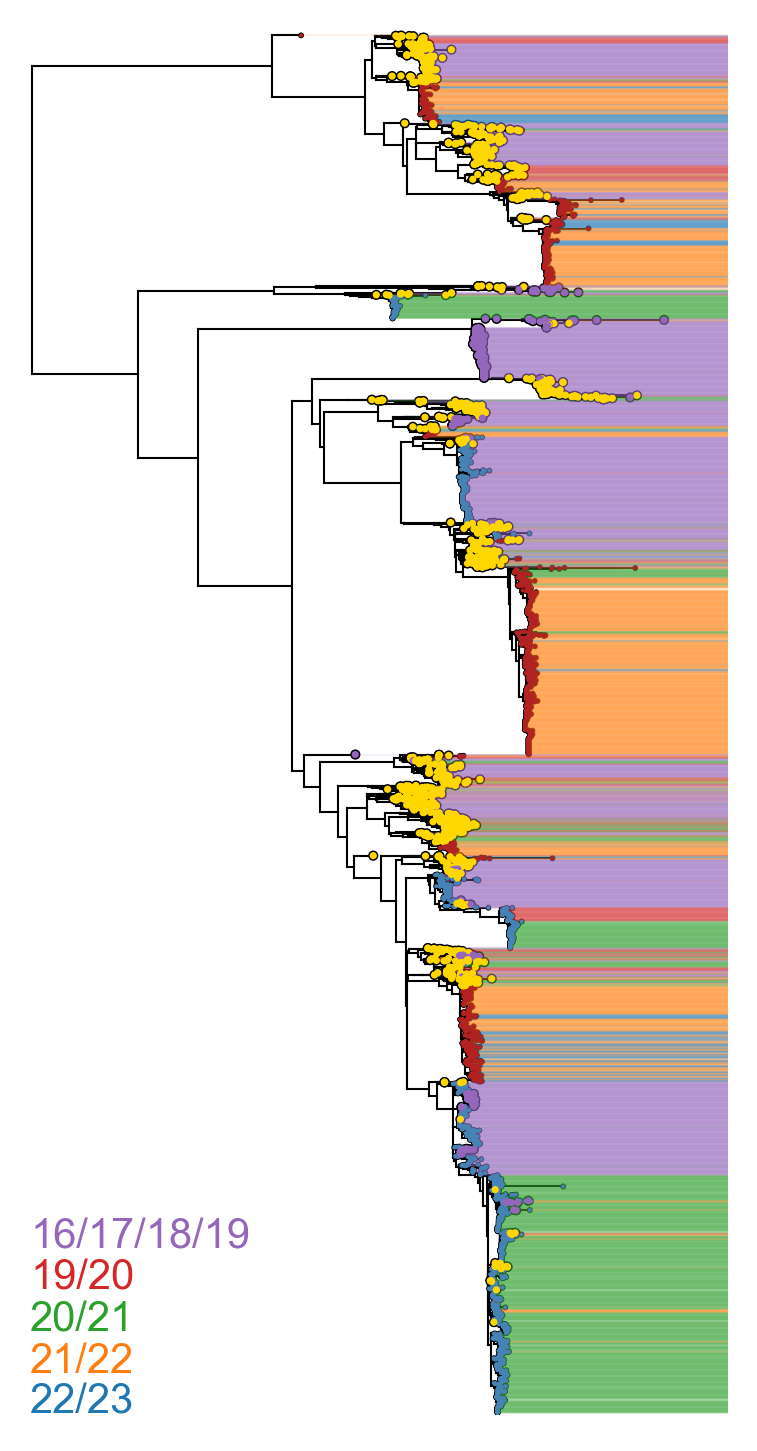

In [21]:
seg = 'PB2'

# seq2isl, seq2date, seq2islname, seq2subtype = meta_data[seg]
ll = bt.loadNexus(f'./blast_res2/treetime_{seg}/divergence_tree.nexus', absoluteTime=False)

for leaf in ll.getExternal():
    isl = seq2isl.get(leaf.name)
    if isl:
        subtype = all_aiv_metainfo.loc[isl, 'Subtype']
        leaf.traits['subtype'] = subtype

fig, ax = plt.subplots(1, 1, figsize=(3, 6), dpi=300)

def tip_color(k):
    subtype = k.traits['subtype']
    if subtype == 'A / H5N8':
        return 'steelblue'
    elif subtype == 'A / H5N1':
        return 'firebrick'
    elif subtype == 'A / H5N6':
        return 'C4'
    else:
        return 'gold'

    
ll.plotTree(ax=ax, width=.5)

ll.plotPoints(ax=ax, size=1, colour=tip_color, target=lambda x: x.is_leaf() and 'subtype' in x.traits and x.traits['subtype'] in ['A / H5N8', 'A / H5N1'])
ll.plotPoints(ax=ax, size=3, colour=tip_color, target=lambda x: x.is_leaf() and 'subtype' in x.traits and x.traits['subtype'] not in ['A / H5N8', 'A / H5N1'])

for leaf in ll.getExternal():
    
    # if not seq2isl.get(leaf.name) in query_set:
    #     continue

    date = seq2date.get(leaf.name)
    if not date:
        continue
    date = bt.decimalDate(date, '%Y-%m-%d')
    if round(date) == 2023:
        c = 'C0'
    elif round(date) == 2022:
        c = 'C1'
    elif round(date) == 2021:
        c = 'C2'
    elif round(date) == 2020:
        c = 'C3'
    elif round(date) == 2017:
        c = 'C4'
    elif round(date) == 2018:
        c = 'C4'
    elif round(date) == 2019:
        c = 'C4'
    else:
        continue
    
    ax.hlines(leaf.y, xmin=leaf.x, xmax=ll.treeHeight*1.1, color=c, lw=.1, alpha=.5, ls='-')

ax.text(0, 0, '22/23', color='C0')
ax.text(0, 200, '21/22', color='C1')
ax.text(0, 400, '20/21', color='C2')
ax.text(0, 600, '19/20', color='C3')
ax.text(0, 800, '16/17/18/19', color='C4')

ax.set(xlim=(0, ll.treeHeight*1.1), ylim=(-10, ll.ySpan+30), xticks=[], yticks=[])

[ax.spines[loc].set_visible(False) for loc in ax.spines]

plt.show()

In [53]:
# dir_path = "/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/02_sequence_of_dataset2/09_ext_group"
# [x for x in os.listdir(dir_path) if x.endswith('.csv')]

In [54]:
# extend = []

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_PB2.csv'), sep='\t')
# sub = genotype.query('PB2=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1PB2+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_PB1.csv'), sep='\t')
# sub = genotype.query('PB1=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1PB1+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_PA.csv'), sep='\t')
# sub = genotype.query('PA=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1PA+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_HA.csv'), sep='\t')
# sub = genotype.query('HA=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1HA+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_NP.csv'), sep='\t')
# sub = genotype.query('NP=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1NP+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_NA.csv'), sep='\t')
# sub = genotype.query('NA=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1NA+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_MP.csv'), sep='\t')
# sub = genotype.query('MP=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1MP+'
# extend.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_1_1_1_1_1_1_1_1_NS.csv'), sep='\t')
# sub = genotype.query('NS=="b"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G1NS+'
# extend.append(tmp)

In [55]:
# extend2 = []

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_PB2.csv'), sep='\t')
# sub = genotype.query('PB2=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0PB2+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_PB1.csv'), sep='\t')
# sub = genotype.query('PB1=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0PB1+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_PA.csv'), sep='\t')
# sub = genotype.query('PA=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0PA+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_HA.csv'), sep='\t')
# sub = genotype.query('HA=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0HA+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_NP.csv'), sep='\t')
# sub = genotype.query('NP=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0NP+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_NA.csv'), sep='\t')
# sub = genotype.query('NA=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0NA+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_MP.csv'), sep='\t')
# sub = genotype.query('MP=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0MP+'
# extend2.append(tmp)

# df = pd.read_csv(os.path.join(dir_path,'ext_0_0_0_0_0_0_0_0_NS.csv'), sep='\t')
# sub = genotype.query('NS=="a"').index

# tmp = df[~df.Isolate_Id.isin(sub)].copy()
# tmp['Extend'] = 'G0NS+'
# extend2.append(tmp)

In [56]:
# pd.concat(extend+extend2, ignore_index=True).to_csv('Supplementary_table_sheet3.csv', sep='\t', index=False)

In [538]:
# tmp = isl_info_h5n8[['Subtype', 'Location', 'Host', 'Collection_Date', 'Domestic_Status']]
# all_aiv_metainfo = pd.concat([all_aiv_metainfo, tmp])
# all_aiv_metainfo = all_aiv_metainfo[~all_aiv_metainfo.index.duplicated(keep='last')]

# all_aiv_metainfo

# fetch sequences by segment

# fetch Group a and Group b for HA gene

## resample dataset at admin-2 level

First, identify monophyletic clades of sequences sampled from the same admin-2 area associated with a bootstrap support higher than 70%. Such phylogenetic clusters of sampled sequences largely represent lineage dispersal within a specific admin-2 ares. Keep more than one sequence per phylogenetic cluster would not contribute any meaningful information in subsequent phylogeographic analyses.  
Second, subsample the original alignment such that only one sequence is randomly selected per phylogenetic cluster. 

In [618]:
seg = 'HA'

number_of_isolates_belong_group_a = genotype.query(f"{seg}=='a'").shape[0]
number_of_isolates_belong_group_b = genotype.query(f"{seg}=='b'").shape[0]

isolates_belong_group_a = genotype.query(f"{seg}=='a'").index.to_list()
isolates_belong_group_b = genotype.query(f"{seg}=='b'").index.to_list()

print(f"number of isolates belong Group A: {number_of_isolates_belong_group_a}\nnumber of isolates belong Group B: {number_of_isolates_belong_group_b}\n")


tree_file = f'./data/01_19to21_h5n8/h5n8_{seg}.align.fasta.treefile'
tree = Tree(tree_file)
R = tree.get_midpoint_outgroup()
tree.set_outgroup(R)
tree.ladderize(1)

tree.describe()
print('\n')

loc_set = []
ct_a, ct_b = 0, 0
print("Nodes not in Group a or Group b: ")
for leaf in tree.iter_leaves():
    seg_acc = leaf.name
    isl_acc = seg2isl.get(seg_acc)

    if not isl_acc:
        leaf.delete()
        print(seg_acc)
        continue
    
    isl_name = all_aiv_metainfo.loc[isl_acc, 'Isolate_Name']
    host = all_aiv_metainfo.loc[isl_acc, 'Host']
    
    loc = all_aiv_metainfo.loc[isl_acc, 'provincie']
    if not loc:
        loc = all_aiv_metainfo.loc[isl_acc, 'country']
    if loc not in loc_set:
        loc_set.append(loc)
    
    leaf.add_features(isl_name=isl_name, loc=loc, host=host)
    leaf.add_face(TextFace(f'{isl_acc} {isl_name} {loc}'), 0, 'branch-right')
    
    if isl_acc in isolates_belong_group_a:
        ct_a += 1
    elif isl_acc in isolates_belong_group_b:
        ct_b += 1
    else:
        print(seg_acc, isl_acc, isl_name)

print('\n')
print(f"Total number of {ct_a} (Group a) and {ct_b} (Group b) in sampled HA tree.\n")


node_l = []
for loc in loc_set:
    for node in tree.get_monophyletic(values=[loc], target_attr='loc'):
        if len(node) >= 2:
            node_l.append(node.get_leaves()[0])
        else:
            node_l.append(node)


tree.prune(node_l)
sampled_seg_acc = tree.get_leaf_names()

tree.describe()

ts = TreeStyle()

ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.show_scale = False

tree.show(tree_style=ts)

number of isolates belong Group A: 1011
number of isolates belong Group B: 312

Number of leaf nodes:	792
Total number of nodes:	1583
Rooted:	Yes
Most distant node:	EPI1949262
Max. distance:	0.038801


Nodes not in Group a or Group b: 
EPI1858826 EPI_ISL_1760448 A/common teal/Shaanxi/SXY1-1/2020
EPI1898024 EPI_ISL_4062441 A/goose/China/21FU005/2020
EPI1898020 EPI_ISL_4062437 A/goose/China/21FU001/2020
EPI1898025 EPI_ISL_4062442 A/goose/China/21FU006/2020
EPI1898023 EPI_ISL_4062440 A/goose/China/21FU004/2020
EPI1898021 EPI_ISL_4062438 A/goose/China/21FU002/2020
EPI1898027 EPI_ISL_4062444 A/goose/China/21FU008/2020
EPI1898026 EPI_ISL_4062443 A/goose/China/21FU007/2020
EPI1898022 EPI_ISL_4062439 A/goose/China/21FU003/2020
EPI1933075
EPI1941579 EPI_ISL_7380253 A/Goose/Jiangsu/21153-2/2021(H5N8)
EPI1933655 EPI_ISL_6829532 A/chicken/Akita/7C/2021
EPI1815373 EPI_ISL_683752 A/Eurasian_wigeon/Italy/20VIR7301-34/2020
EPI1815381 EPI_ISL_683751 A/Eurasian_wigeon/Italy/20VIR7301-31/2020
EPI1846961


## add related isolates based on blastn

In [619]:
blast_seqs = SeqIO.to_dict(SeqIO.parse('./blast_res/blast.HA.fasta', 'fasta'))

In [620]:
all_aiv_metainfo.loc[['EPI_ISL_11325045', 'EPI_ISL_11325047'], :]

Isolate_Name   Subtype  \
Isolate_Id                                                               
EPI_ISL_11325045  A/chicken/Egypt/Elmonufia-backyard-AH/2019  A / H5N8   
EPI_ISL_11325047         A/chicken/Egypt/Cairo-HC11B-AH/2020  A / H5N8   

                                       Location     Host Collection_Date  \
Isolate_Id                                                                 
EPI_ISL_11325045  Africa / Egypt / El-Monoufiya  Chicken      1905-07-11   
EPI_ISL_11325047         Africa / Egypt / Cairo  Chicken      1905-07-12   

                 Domestic_Status       date     host  region country  \
Isolate_Id                                                             
EPI_ISL_11325045                 1905-07-11  chicken  Africa   Egypt   
EPI_ISL_11325047                 1905-07-12  chicken  Africa   Egypt   

                     provincie city  
Isolate_Id                           
EPI_ISL_11325045  El-Monoufiya       
EPI_ISL_11325047         Cairo

Number of leaf nodes:	478
Total number of nodes:	951
Rooted:	Yes
Most distant node:	EPI1941715
Max. distance:	0.033387

EPI1176526 EPI_ISL_298649 Turkey Asia / Israel 2017-02-05 atggagaaaatagtgcttcttcttgcaatagttagccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagcaagttgaca  ...
EPI1585011 EPI_ISL_389751 Gallus gallus Africa / Egypt 2017-05-10 atggagaacatagtgcttcttcttgcaatagttagccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagcaagttgaca  ...
EPI1772327 EPI_ISL_502280 Gallus gallus Africa / Egypt 2018-02-05 atggagaacatagtgcttcttcttgcaatagttagccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagcaagttgaca  ...
EPI1381433 EPI_ISL_344536 Chicken Africa / Egypt / EL-Menia 2018-03-10 ------------gtgcttcttcttgcaatagttagccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagcaagttgaca  ...
EPI1381426 EPI_ISL_344533 Duck Africa / Egypt / Fayoum 2018-01-11 --------aatagtgcttcttcttgcaatagttagccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagcaagttgaca  ...
EPI1901636 EPI_ISL_4069

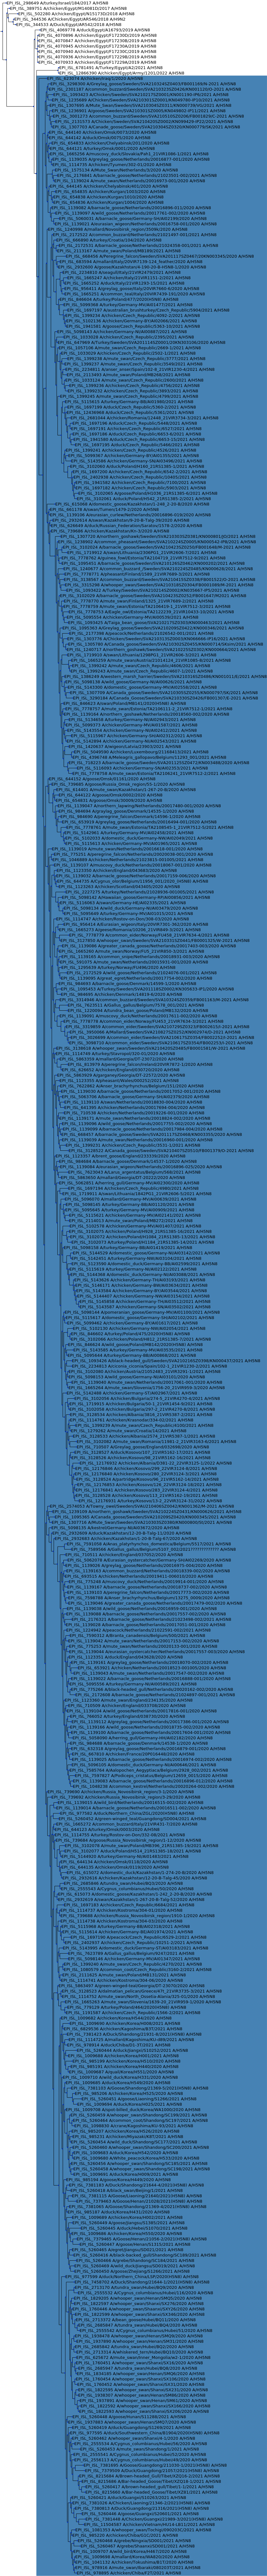

In [626]:
# fetch all isolate acc
isolates_in_query_group = isolates_belong_group_a

# set sampled isolates
sampled_seg_acc = sampled_seg_acc

# read and set blast tree
tree_file = f'./blast_res/blast2.{seg}.tree'
tree = Tree(tree_file)
R = tree.get_midpoint_outgroup()
tree.set_outgroup(R)
tree.ladderize(1)

# unify tree
for leaf in tree.iter_leaves():
    seg_acc = leaf.name
    isl_acc = seg2isl.get(seg_acc)
    isl_name = seg2strain.get(seg_acc)
    subtype = seg2subtype.get(seg_acc)
    
    if not isl_acc:
        leaf.delete()
        continue
    
    if isl_acc in ['EPI_ISL_11325045', 'EPI_ISL_11325047']:
        leaf.delete()
        continue
    
    leaf.add_features(isl_name=isl_name, isl_acc=isl_acc, subtype=subtype)
    leaf.add_face(TextFace(f'{isl_acc} {isl_name} {subtype}'), 0, 'branch-right')


# filter leaf node with specified group index
leaf_node_set = [l for l in tree.iter_leaves() if l.isl_acc in isolates_in_query_group]
# filter leaf node with specified sampling set
sub_leaf_set = [l for l in leaf_node_set if l.name in sampled_seg_acc]
# sub_leaf_set = leaf_node_set

mrca = tree.get_common_ancestor(leaf_node_set)
subtree = mrca.up.up.up.up

other_leaf_set = [l for l in subtree.iter_leaves() if l.isl_acc and l not in mrca.get_leaves()]

subtree.prune(other_leaf_set+sub_leaf_set)
tree.ladderize(0)

mrca.img_style['bgcolor'] = 'steelblue'

subtree.describe()
print()

# make mas file for BEAST analysis
unique_seqs = []
ha_seqs_with_group_b = []
for leaf in subtree.get_leaf_names():
    isl_acc = seg2isl[leaf]
    host = all_aiv_metainfo.loc[isl_acc, 'Host']
    loc = all_aiv_metainfo.loc[isl_acc, 'Location']
    time = all_aiv_metainfo.loc[isl_acc, 'Collection_Date']
    time = pd.to_datetime(time).strftime("%Y-%m-%d")
    
    print(leaf, isl_acc, host, loc, time, blast_seqs[leaf].seq[:100], ' ...')
    record = blast_seqs[leaf]
    record.id = f'{leaf}|{isl_acc}|{time}'
    record.name = ''
    record.description = ''
    seq = str(record.seq)
    if seq not in unique_seqs:
        ha_seqs_with_group_b.append(record)
        unique_seqs.append(str(record.seq))

# SeqIO.write(ha_seqs_with_group_b, './data/01_ha_for_beast/ha_group_b.fasta', 'fasta')

ts = TreeStyle()

ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.show_scale = False

# subtree.show(tree_style=ts)
subtree.render("%%inline", tree_style=ts)



Number of leaf nodes:	206
Total number of nodes:	390
Rooted:	Yes
Most distant node:	EPI1847772
Max. distance:	0.035163

EPI1701660 EPI_ISL_412988 Chicken Asia / Iran, Islamic Republic of 2017-01-05 atggagaacatagtgcttcttcttgcaatagttagccttgttgaaagtgatcagatttgcattggttaccatgcaaacaactcgacagagcaagttgaca  ...
EPI1176530 EPI_ISL_298653 Falco peregrinus Asia / Israel 2016-12-25 atggagaaaatagtgcttcttcttgcaatagttagccttgttgaaagtgatcagatttgcattggttaccatgcaaacaactcgacagagcaagttgaca  ...
EPI1176527 EPI_ISL_298650 Turkey Asia / Israel 2016-12-24 atggagaaaatagtgcttcttcttgcaatagttagccttgttgaaagtgatcagatttgcattggttaccatgcaaacaactcgacagagcaagttgaca  ...
EPI1701691 EPI_ISL_412992 Chicken Asia / Iran, Islamic Republic of 2017-01-23 atggagaacatagtgcttcttcttgcaatagttagccttgttgaaagtgatcagatttgcattggttaccatgcaaacaactcgacagagcaagttgaca  ...
EPI1701725 EPI_ISL_412997 Chicken Asia / Iran, Islamic Republic of 2017-10-16 atggagaacatagtgcttcttcttgcaatagttagccttgttgaaagtgatcagatttgcattggttaccatgcaaacaactcgacagagcaagtt

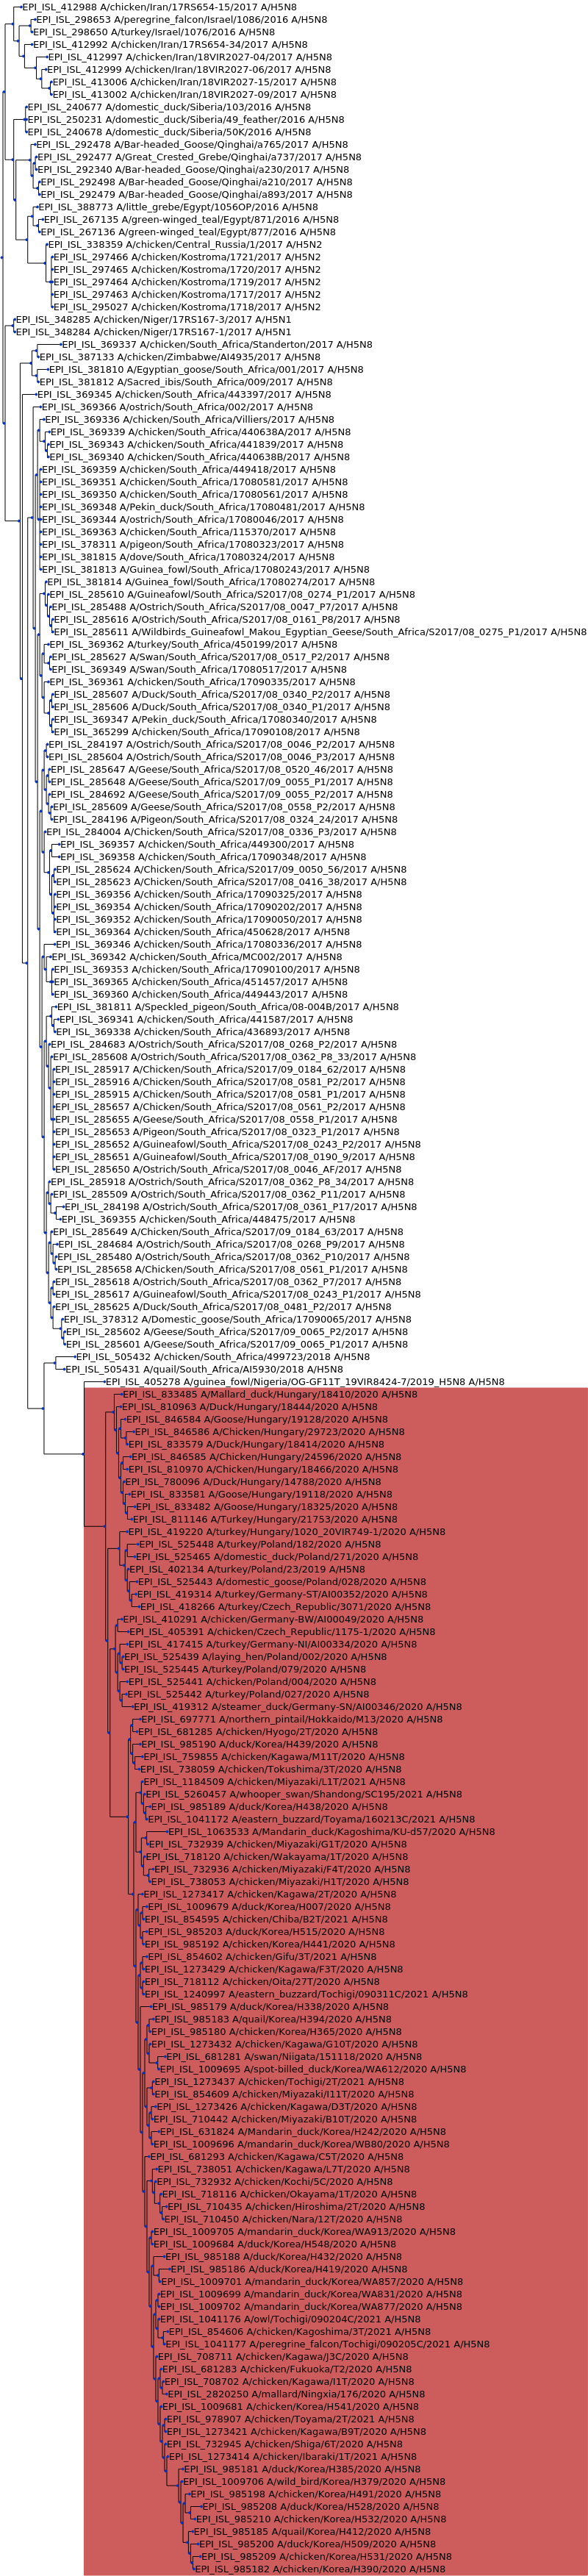

In [624]:
# seg = 'HA'

# fetch all isolate acc
isolates_in_query_group = isolates_belong_group_b

# set sampled isolates
sampled_seg_acc = sampled_seg_acc

# read and set blast tree
tree_file = f'./blast_res/blast2.{seg}.tree'
tree = Tree(tree_file)
R = tree.get_midpoint_outgroup()
tree.set_outgroup(R)
tree.ladderize(1)

# unify tree
for leaf in tree.iter_leaves():
    seg_acc = leaf.name
    isl_acc = seg2isl.get(seg_acc)
    isl_name = seg2strain.get(seg_acc)
    subtype = seg2subtype.get(seg_acc)
    
    if not isl_acc:
        leaf.delete()
        continue
    
    if isl_acc in ['EPI_ISL_11325045', 'EPI_ISL_11325047']:
        leaf.delete()
        continue
    
    leaf.add_features(isl_name=isl_name, isl_acc=isl_acc, subtype=subtype)
    leaf.add_face(TextFace(f'{isl_acc} {isl_name} {subtype}'), 0, 'branch-right')


# filter leaf node with specified group index
leaf_node_set = [l for l in tree.iter_leaves() if l.isl_acc in isolates_in_query_group]
# filter leaf node with specified sampling set
sub_leaf_set = [l for l in leaf_node_set if l.name in sampled_seg_acc]
# sub_leaf_set = leaf_node_set

mrca = tree.get_common_ancestor(leaf_node_set)
subtree = mrca.up.up.up.up.up.up.up

other_leaf_set = [l for l in subtree.iter_leaves() if l.isl_acc and l not in mrca.get_leaves()]

subtree.prune(other_leaf_set+sub_leaf_set)
tree.ladderize(0)

mrca.img_style['bgcolor'] = '#CD5C5C'

subtree.describe()
print()

# make mas file for BEAST analysis
unique_seqs = []
ha_seqs_with_group_b = []
for leaf in subtree.get_leaf_names():
    isl_acc = seg2isl[leaf]
    host = all_aiv_metainfo.loc[isl_acc, 'Host']
    loc = all_aiv_metainfo.loc[isl_acc, 'Location']
    time = all_aiv_metainfo.loc[isl_acc, 'Collection_Date']
    time = pd.to_datetime(time).strftime("%Y-%m-%d")
    
    print(leaf, isl_acc, host, loc, time, blast_seqs[leaf].seq[:100], ' ...')
    record = blast_seqs[leaf]
    record.id = f'{leaf}|{isl_acc}|{time}'
    record.name = ''
    record.description = ''
    seq = str(record.seq)
    if seq not in unique_seqs:
        ha_seqs_with_group_b.append(record)
        unique_seqs.append(str(record.seq))

# SeqIO.write(ha_seqs_with_group_b, './data/01_ha_for_beast/ha_group_b.fasta', 'fasta')

ts = TreeStyle()

ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.show_scale = False

# subtree.show(tree_style=ts)
subtree.render("%%inline", tree_style=ts)



In [630]:
acc_l = [seg2isl[x] for x in subtree.get_leaf_names()]
all_aiv_metainfo.loc[acc_l, :]

Isolate_Name   Subtype  \
Isolate_Id                                                    
EPI_ISL_298649           A/turkey/Israel/184/2017  A / H5N8   
EPI_ISL_389751       A/chicken/Egypt/M14081D/2017  A / H5N8   
EPI_ISL_502280       A/chicken/Egypt/N15173D/2018  A / H5N8   
EPI_ISL_344536         A/Chicken/Egypt/AR546/2018  A / H9N2   
EPI_ISL_344533            A/Duck/Egypt/AR542/2018  A / H5N8   
...                                           ...       ...   
EPI_ISL_1009707       A/wild bird/Korea/H467/2020  A / H5N8   
EPI_ISL_1009698        A/mallard/Korea/WA820/2020  A / H5N8   
EPI_ISL_1041132      A/chicken/Tokushima/B1T/2020  A / H5N8   
EPI_ISL_978916   A/mute swan/Ibaraki/080203T/2021  A / H5N8   
EPI_ISL_978895           A/chicken/Chiba/F2T/2021  A / H5N8   

                                       Location           Host  \
Isolate_Id                                                       
EPI_ISL_298649                    Asia / Israel         Turkey   
EPI_ISL_389751                   Africa / Egypt  Gallus gallus   
EPI_ISL_502280                   Africa / Egypt  Gallus gallus   
EPI_ISL_344536        Africa / Egypt / EL-Menia        Chicken   
EPI_ISL_344533          Africa / Egypt / Fayoum           Duck   
...                                         ...            ...   
EPI_ISL_1009707  Asia / Korea, Republic of / CB          Avian   
EPI_ISL_1009698  Asia / Korea, Republic of / GG          Avian   
EPI_ISL_1041132        Asia / Japan / Tokushima        Chicken   
EPI_ISL_978916           Asia / Japan / Ibaraki           Swan   
EPI_ISL_978895             Asia / Japan / Chiba        Chicken   

                Collection_Date Domestic_Status       date       host  region  \
Isolate_Id                                                                      
EPI_ISL_298649       2017-02-05                 2017-02-05     turkey    Asia   
EPI_ISL_389751       2017-05-10                 2017-05-10    chicken  Africa   
EPI_ISL_502280       2018-02-05                 2018-02-05    chicken  Africa   
EPI_ISL_344536       2018-03-10                 2018-03-10    Chicken  Africa   
EPI_ISL_344533       2018-01-11                 2018-01-11       Duck  Africa   
...                         ...             ...        ...        ...     ...   
EPI_ISL_1009707      2020-12-14                 2020-12-14  wild bird    Asia   
EPI_ISL_1009698      2020-11-25                 2020-11-25    mallard    Asia   
EPI_ISL_1041132      2021-02-08                 2021-02-08    chicken    Asia   
EPI_ISL_978916       2021-02-01                 2021-02-01  mute swan    Asia   
EPI_ISL_978895       2021-02-05                 2021-02-05    chicken    Asia   

                            country  provincie city  
Isolate_Id                                           
EPI_ISL_298649               Israel                  
EPI_ISL_389751                Egypt                  
EPI_ISL_502280                Egypt                  
EPI_ISL_344536                Egypt   EL-Menia       
EPI_ISL_344533                Egypt     Fayoum       
...                             ...        ...  ...  
EPI_ISL_1009707  Korea, Republic of         CB       
EPI_ISL_1009698  Korea, Republic of         GG       
EPI_ISL_1041132               Japan  Tokushima       
EPI_ISL_978916                Japan    Ibaraki       
EPI_ISL_978895                Japan      Chiba       

[478 rows x 12 columns]